# Imports

In [88]:
import pyspark
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create pyspark session

In [2]:
spark = SparkSession.builder \
    .appName("Houce Price prediciton") \
    .master("local[*]") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.cores", "4") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "10g") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()

print("Spark session created with custom configurations.")

Spark session created with custom configurations.


# Import dataset

In [3]:
dfs_house=spark.read.csv('../data/kc_house_data.csv',header=True,inferSchema=True)

In [4]:
dfs_house.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)




### Dataset Variable Descriptions

- **id** : Unique identifier for each property sale.
- **date** : Date of the home sale, formatted as a string.
- **price** : Sale price of each home, which is the target variable for prediction.
- **bedrooms** : Number of bedrooms in the house.
- **bathrooms** : Number of bathrooms in the house, including partial bathrooms.
- **sqft_living** : Square footage of the interior living space.
- **sqft_lot** : Square footage of the lot.
- **floors** : Number of floors in the property.
- **waterfront** : Binary indicator of whether the property has a waterfront view (1 = yes, 0 = no).
- **view** : An index from 0 to 4 indicating the quality of the view.
- **condition** : Overall condition rating of the property, on a scale from 1 to 5.
- **grade** : An index from 1 to 13 indicating the construction and design quality of the property, with higher values representing better quality.
- **sqft_above** : Square footage of the house above ground level.
- **sqft_basement** : Square footage of the basement in the property.
- **yr_built** : Year the property was built.
- **yr_renovated** : Year of the most recent renovation. A value of 0 indicates no renovation.
- **zipcode** : ZIP code of the property, representing its location.
- **lat** : Latitude coordinate of the property.
- **long** : Longitude coordinate of the property.
- **sqft_living15** : Average square footage of living space for the 15 nearest neighboring properties.
- **sqft_lot15** : Average square footage of the lot for the 15 nearest neighboring properties.

## Persist and count

In [5]:
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).count()

21613

With 21613 values, the use of pyspark seems appropriate, and its possible to persist the dataframe

In [6]:
dfs_house.show()

+----------+---------------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|           date|    price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+---------------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013T000000| 221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|
|6414100192|20141209T000000| 538000.0|       3|     2.25|       2570|    7242|   2.0|         0|   0|        3|    7|      2170|          40

# Cleaning

### Check null values

In [7]:
for column in dfs_house.columns:
    null_count = dfs_house.filter(col(column).isNull()).count()
    if null_count > 0:
        print(f"Column '{column}' has {null_count} null values.")
    else:
        print(f"Column '{column}' has no null values.")

Column 'id' has no null values.
Column 'date' has no null values.
Column 'price' has no null values.
Column 'bedrooms' has no null values.
Column 'bathrooms' has no null values.
Column 'sqft_living' has no null values.
Column 'sqft_lot' has no null values.
Column 'floors' has no null values.
Column 'waterfront' has no null values.
Column 'view' has no null values.
Column 'condition' has no null values.
Column 'grade' has no null values.
Column 'sqft_above' has no null values.
Column 'sqft_basement' has no null values.
Column 'yr_built' has no null values.
Column 'yr_renovated' has no null values.
Column 'zipcode' has no null values.
Column 'lat' has no null values.
Column 'long' has no null values.
Column 'sqft_living15' has no null values.
Column 'sqft_lot15' has no null values.


### Unique ids

In [8]:
duplicate_ids = dfs_house.groupBy("id").count().filter(col("count") > 1)

# Afficher les doublons s'il y en a
if duplicate_ids.count() > 0:
    print(f"Il existe {duplicate_ids.count()} doublons dans la colonne 'id'. Voici les ids en double :")
    duplicate_ids.show()
else:
    print("Aucun doublon n'a été trouvé dans la colonne 'id'.")

Il existe 176 doublons dans la colonne 'id'. Voici les ids en double :
+----------+-----+
|        id|count|
+----------+-----+
|2023049218|    2|
|2787460720|    2|
|7853400250|    2|
|8121100395|    2|
| 123039336|    2|
|6021501535|    2|
|3333002450|    2|
| 641900050|    2|
|1825069031|    2|
|2019200220|    2|
|3578401060|    2|
|8910500150|    2|
|7409700215|    2|
|8820903380|    2|
|4443800385|    2|
|7899800045|    2|
|4204400098|    2|
|3523069060|    2|
|   1000102|    2|
|8682262400|    2|
+----------+-----+
only showing top 20 rows



In [9]:
duplicates_df = dfs_house.join(duplicate_ids, on="id", how="inner")

duplicates_dfs = duplicates_df.groupBy(dfs_house.columns).count().filter(col("count") > 1)

if duplicates_dfs.count() > 0:
    print("Certaines lignes avec des IDs en double sont entièrement identiques.")
    duplicates_dfs.show()
else:
    print("Les lignes avec des IDs en double ne sont pas identiques.")

Les lignes avec des IDs en double ne sont pas identiques.


It looks like some house have been sold at least 2 times in a year

In [10]:
duplicates_df.show()

+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+-----+
|        id|           date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|count|
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+-----+
|2023049218|20150316T000000|445000.0|       2|      1.0|        930|    7740|   1.0|         0|   0|        1|    5|       930|            0|    1932|           0|  98148|47.4611|-122.324|         1620|      8584|    2|
|2023049218|20140716T000000|105500.0|       2|      1.0|        930|    7740|   1.0|         0|   0|        1|    5|    

### Comparison price

In [11]:
duplicates_df = duplicates_df.withColumn("date_ts", F.to_timestamp(F.col("date").substr(1, 8), "yyyyMMdd"))

window_spec = Window.partitionBy("id").orderBy("date_ts")

duplicates_df = duplicates_df.withColumn("row_num", F.row_number().over(window_spec))

first_sale_df = duplicates_df.filter(F.col("row_num") == 1).select('id','date','price')
second_sale_df = duplicates_df.filter(F.col("row_num") == 2).select('id','date','price')

first_sale_df.show(truncate=False)
second_sale_df.show(truncate=False)

+----------+---------------+--------+
|id        |date           |price   |
+----------+---------------+--------+
|1000102   |20140916T000000|280000.0|
|7200179   |20141016T000000|150000.0|
|109200390 |20140820T000000|245000.0|
|123039336 |20140611T000000|148000.0|
|251300110 |20140731T000000|225000.0|
|302000375 |20140814T000000|169100.0|
|324000530 |20140708T000000|201500.0|
|526059224 |20140923T000000|260000.0|
|641900050 |20140819T000000|335000.0|
|643300040 |20141104T000000|481000.0|
|705730280 |20140819T000000|325000.0|
|722039087 |20140923T000000|220500.0|
|723049156 |20140523T000000|149000.0|
|726049190 |20141002T000000|287500.0|
|795000620 |20140924T000000|115000.0|
|937000330 |20141224T000000|157000.0|
|1036400200|20150213T000000|661000.0|
|1139600270|20140701T000000|300000.0|
|1217000340|20140606T000000|185000.0|
|1219000473|20140626T000000|164950.0|
+----------+---------------+--------+
only showing top 20 rows

+----------+---------------+--------+
|id        |date        

In [12]:
first_sale_df = first_sale_df.withColumnRenamed("date", "first_date") \
                             .withColumnRenamed("price", "first_sale_price")

second_sale_df = second_sale_df.withColumnRenamed("date", "second_date") \
                               .withColumnRenamed("price", "second_sale_price")

combined_dfs = first_sale_df.join(second_sale_df, on="id", how="inner")
combined_dfs = combined_dfs.withColumn("price_difference", F.col("second_sale_price") - F.col("first_sale_price"))

combined_dfs.show(truncate=False)

+----------+---------------+----------------+---------------+-----------------+----------------+
|id        |first_date     |first_sale_price|second_date    |second_sale_price|price_difference|
+----------+---------------+----------------+---------------+-----------------+----------------+
|1000102   |20140916T000000|280000.0        |20150422T000000|300000.0         |20000.0         |
|7200179   |20141016T000000|150000.0        |20150424T000000|175000.0         |25000.0         |
|109200390 |20140820T000000|245000.0        |20141020T000000|250000.0         |5000.0          |
|123039336 |20140611T000000|148000.0        |20141208T000000|244900.0         |96900.0         |
|251300110 |20140731T000000|225000.0        |20150114T000000|358000.0         |133000.0        |
|302000375 |20140814T000000|169100.0        |20150506T000000|250000.0         |80900.0         |
|324000530 |20140708T000000|201500.0        |20150323T000000|459000.0         |257500.0        |
|526059224 |20140923T000000|26

In [13]:
combined_dfs.persist(StorageLevel.MEMORY_AND_DISK).count()

176

In [14]:
average_price = combined_dfs.agg(F.avg("first_sale_price")).first()[0]

# Define a margin as 2% of the average price
negligible_margin = average_price * 0.03

combined_df = combined_dfs.withColumn(
    "is_negligible", F.abs(F.col("price_difference")) <= negligible_margin
)

negligible_df = combined_df.filter(F.col("is_negligible") == True)
negligible_df.show(truncate=False)
negligible_df.count()

+----------+---------------+----------------+---------------+-----------------+----------------+-------------+
|id        |first_date     |first_sale_price|second_date    |second_sale_price|price_difference|is_negligible|
+----------+---------------+----------------+---------------+-----------------+----------------+-------------+
|1825069031|20140814T000000|550000.0        |20141016T000000|550000.0         |0.0             |true         |
|8682262400|20140718T000000|430000.0        |20150513T000000|419950.0         |-10050.0        |true         |
|795000620 |20140924T000000|115000.0        |20141215T000000|124000.0         |9000.0          |true         |
|9222400605|20141115T000000|842500.0        |20150411T000000|850000.0         |7500.0          |true         |
|7701960990|20140616T000000|862000.0        |20140819T000000|870000.0         |8000.0          |true         |
|1139600270|20140701T000000|300000.0        |20150324T000000|310000.0         |10000.0         |true         |
|

13

#### Filter out the found duplicates

In [15]:
negligible_ids=negligible_df.select('id')
dfs_house = dfs_house.join(negligible_ids, on="id", how="left_anti")
dfs_house.show(truncate=False)
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).count()
combined_dfs.unpersist()

+----------+---------------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|id        |date           |price    |bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|lat    |long    |sqft_living15|sqft_lot15|
+----------+---------------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013T000000|221900.0 |3       |1.0      |1180       |5650    |1.0   |0         |0   |3        |7    |1180      |0            |1955    |0           |98178  |47.5112|-122.257|1340         |5650      |
|6414100192|20141209T000000|538000.0 |3       |2.25     |2570       |7242    |2.0   |0         |0   |3        |7    |2170      |400         

DataFrame[id: bigint, first_date: string, first_sale_price: double, second_date: string, second_sale_price: double, price_difference: double]

### Clean bathroom and floors data

In [16]:
dfs_house = dfs_house.withColumn("bathrooms", F.round(F.col("bathrooms")).cast("integer")) \
                     .withColumn("floors", F.round(F.col("floors")).cast("integer"))

dfs_house.select("bathrooms", "floors").show(truncate=False)

+---------+------+
|bathrooms|floors|
+---------+------+
|1        |1     |
|2        |2     |
|1        |1     |
|3        |1     |
|2        |1     |
|5        |1     |
|2        |2     |
|2        |1     |
|1        |1     |
|3        |2     |
|3        |1     |
|1        |1     |
|1        |2     |
|2        |1     |
|2        |2     |
|3        |2     |
|2        |2     |
|1        |2     |
|1        |1     |
|1        |1     |
+---------+------+
only showing top 20 rows



In [17]:
dfs_house.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[id: bigint, date: string, price: double, bedrooms: int, bathrooms: int, sqft_living: int, sqft_lot: int, floors: int, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, yr_built: int, yr_renovated: int, zipcode: int, lat: double, long: double, sqft_living15: int, sqft_lot15: int]

In [18]:
dfs_house.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: integer (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



# Transform dataset

### Date

In [19]:
dfs_house = dfs_house.withColumn("dateTime", F.to_timestamp(F.col("date").substr(1, 8), "yyyyMMdd")) \
                     .withColumn("year_of_sale", F.year("dateTime"))

# Show the resulting DataFrame with the new columns
dfs_house.select("date", "dateTime", "year_of_sale").show(truncate=False)

+---------------+-------------------+------------+
|date           |dateTime           |year_of_sale|
+---------------+-------------------+------------+
|20141013T000000|2014-10-13 00:00:00|2014        |
|20141209T000000|2014-12-09 00:00:00|2014        |
|20150225T000000|2015-02-25 00:00:00|2015        |
|20141209T000000|2014-12-09 00:00:00|2014        |
|20150218T000000|2015-02-18 00:00:00|2015        |
|20140512T000000|2014-05-12 00:00:00|2014        |
|20140627T000000|2014-06-27 00:00:00|2014        |
|20150115T000000|2015-01-15 00:00:00|2015        |
|20150415T000000|2015-04-15 00:00:00|2015        |
|20150312T000000|2015-03-12 00:00:00|2015        |
|20150403T000000|2015-04-03 00:00:00|2015        |
|20140527T000000|2014-05-27 00:00:00|2014        |
|20140528T000000|2014-05-28 00:00:00|2014        |
|20141007T000000|2014-10-07 00:00:00|2014        |
|20150312T000000|2015-03-12 00:00:00|2015        |
|20150124T000000|2015-01-24 00:00:00|2015        |
|20140731T000000|2014-07-31 00:

In [20]:
reference_date = F.to_date(F.lit("2014-05-01")) #la dataset répertorie les ventes à partir de Mai2014

dfs_house = dfs_house.withColumn("number_of_days", F.datediff(F.col("dateTime"), reference_date))

dfs_house.select("date", "dateTime", "number_of_days").show(truncate=False)

+---------------+-------------------+--------------+
|date           |dateTime           |number_of_days|
+---------------+-------------------+--------------+
|20141013T000000|2014-10-13 00:00:00|165           |
|20141209T000000|2014-12-09 00:00:00|222           |
|20150225T000000|2015-02-25 00:00:00|300           |
|20141209T000000|2014-12-09 00:00:00|222           |
|20150218T000000|2015-02-18 00:00:00|293           |
|20140512T000000|2014-05-12 00:00:00|11            |
|20140627T000000|2014-06-27 00:00:00|57            |
|20150115T000000|2015-01-15 00:00:00|259           |
|20150415T000000|2015-04-15 00:00:00|349           |
|20150312T000000|2015-03-12 00:00:00|315           |
|20150403T000000|2015-04-03 00:00:00|337           |
|20140527T000000|2014-05-27 00:00:00|26            |
|20140528T000000|2014-05-28 00:00:00|27            |
|20141007T000000|2014-10-07 00:00:00|159           |
|20150312T000000|2015-03-12 00:00:00|315           |
|20150124T000000|2015-01-24 00:00:00|268      

In [21]:
dfs_house=dfs_house.drop('date','dateTime')
dfs_house.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[id: bigint, price: double, bedrooms: int, bathrooms: int, sqft_living: int, sqft_lot: int, floors: int, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, yr_built: int, yr_renovated: int, zipcode: int, lat: double, long: double, sqft_living15: int, sqft_lot15: int, year_of_sale: int, number_of_days: int]

In [22]:
dfs_house = dfs_house.withColumn("age_house", F.col("year_of_sale") - F.col("yr_built"))
dfs_house = dfs_house.withColumn(
    "yr_renovated",
    F.when(F.col("yr_renovated") == 0, F.col("yr_built")).otherwise(F.col("yr_renovated"))
)
dfs_house = dfs_house.withColumn("year_since_renovation", F.col("year_of_sale") - F.col("yr_renovated"))

dfs_house.select("yr_built", "year_of_sale", "age_house","year_since_renovation",'yr_renovated').show(truncate=False)

+--------+------------+---------+---------------------+------------+
|yr_built|year_of_sale|age_house|year_since_renovation|yr_renovated|
+--------+------------+---------+---------------------+------------+
|1955    |2014        |59       |59                   |1955        |
|1951    |2014        |63       |23                   |1991        |
|1933    |2015        |82       |82                   |1933        |
|1965    |2014        |49       |49                   |1965        |
|1987    |2015        |28       |28                   |1987        |
|2001    |2014        |13       |13                   |2001        |
|1995    |2014        |19       |19                   |1995        |
|1963    |2015        |52       |52                   |1963        |
|1960    |2015        |55       |55                   |1960        |
|2003    |2015        |12       |12                   |2003        |
|1965    |2015        |50       |50                   |1965        |
|1942    |2014        |72       |7

In [23]:
dfs_house=dfs_house.drop('yr_built','year_of_sale','yr_renovated')
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).show()

+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+-------+-------+--------+-------------+----------+--------------+---------+---------------------+
|        id|    price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|zipcode|    lat|    long|sqft_living15|sqft_lot15|number_of_days|age_house|year_since_renovation|
+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+-------+-------+--------+-------------+----------+--------------+---------+---------------------+
|7129300520| 221900.0|       3|        1|       1180|    5650|     1|         0|   0|        3|    7|      1180|            0|  98178|47.5112|-122.257|         1340|      5650|           165|       59|                   59|
|6414100192| 538000.0|       3|        2|       2570|    7242|     2|         0|   0|        3|    7|   

### Localisation

#### Density pop and city name by zip code

I will first import another dataset to add data (from simplemaps)

In [44]:
dfs_zip_us=spark.read.csv('../data/uszips_updated.csv',header=True,inferSchema=True)
dfs_zip_us.printSchema()

root
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- zcta: boolean (nullable = true)
 |-- parent_zcta: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- density: double (nullable = true)
 |-- county_fips: integer (nullable = true)
 |-- county_name: string (nullable = true)
 |-- county_weights: string (nullable = true)
 |-- county_names_all: string (nullable = true)
 |-- county_fips_all: string (nullable = true)
 |-- imprecise: string (nullable = true)
 |-- military: string (nullable = true)
 |-- timezone: string (nullable = true)



In [45]:
#We filter out to only keep zip from the King County in WA
dfs_zip_us=dfs_zip_us.filter(col('county_name')=='King')
dfs_zip_us=dfs_zip_us.filter(col('state_id')=='WA')
dfs_zip_us.show()
dfs_zip_us.persist(StorageLevel.MEMORY_AND_DISK).count()

+-----+--------+----------+-------------+--------+----------+----+-----------+----------+-------+-----------+-----------+------------------+-------------------+---------------+-----------+--------+-------------------+
|  zip|     lat|       lng|         city|state_id|state_name|zcta|parent_zcta|population|density|county_fips|county_name|    county_weights|   county_names_all|county_fips_all|  imprecise|military|           timezone|
+-----+--------+----------+-------------+--------+----------+----+-----------+----------+-------+-----------+-----------+------------------+-------------------+---------------+-----------+--------+-------------------+
|98001|47.30919|-122.26426|       Auburn|      WA|Washington|true|       NULL|     35842|  742.6|      53033|       King|"{""53033"": 100}"|               King|          53033|      FALSE|   FALSE|America/Los_Angeles|
|98002| 47.3082|-122.21567|       Auburn|      WA|Washington|true|       NULL|     36812| 1984.0|      53033|       King|"{""530

86

In [46]:
dfs_zip_us=dfs_zip_us.select('zip','population','density','city')
dfs_zip_us.show()

+-----+----------+-------+-------------+
|  zip|population|density|         city|
+-----+----------+-------+-------------+
|98001|     35842|  742.6|       Auburn|
|98002|     36812| 1984.0|       Auburn|
|98003|     51329| 1723.2|  Federal Way|
|98004|     39161| 2079.8|     Bellevue|
|98005|     22030| 1159.1|     Bellevue|
|98006|     39753| 1365.6|     Bellevue|
|98007|     27571| 2464.1|     Bellevue|
|98008|     27060| 1879.5|     Bellevue|
|98010|      6128|  159.2|Black Diamond|
|98011|     27573| 1509.1|      Bothell|
|98014|      7626|   33.8|    Carnation|
|98019|     11281|  122.1|       Duvall|
|98022|     22163|   11.8|     Enumclaw|
|98023|     50778| 1910.0|  Federal Way|
|98024|      5066|   88.6|    Fall City|
|98025|         0|    0.0|       Hobart|
|98027|     27915|  188.5|     Issaquah|
|98028|     23611| 1482.9|      Kenmore|
|98029|     31227| 1185.1|     Issaquah|
|98030|     38798| 2083.5|         Kent|
+-----+----------+-------+-------------+
only showing top

### Merge the two dataset

In [47]:
dfs_house = dfs_house.join(
    dfs_zip_us.select("zip", "population", "density", "city"),
    dfs_house["zipcode"] == dfs_zip_us["zip"],
    "left"
)

In [49]:
dfs_house=dfs_house.drop('lat','long')
dfs_house.show()

+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+-------+-------------+----------+--------------+---------+---------------------+-----+----------+-------+------------+
|        id|    price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|zipcode|sqft_living15|sqft_lot15|number_of_days|age_house|year_since_renovation|  zip|population|density|        city|
+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+-------+-------------+----------+--------------+---------+---------------------+-----+----------+-------+------------+
|7129300520| 221900.0|       3|        1|       1180|    5650|     1|         0|   0|        3|    7|      1180|            0|  98178|         1340|      5650|           165|       59|                   59|98178|     26760| 2108.1|     Seattle|
|6414100192| 538000.

In [50]:
dfs_house = dfs_house.withColumnRenamed("population", "zip_population") \
                     .withColumnRenamed("density", "zip_density")

Check if null values have been introduced

In [51]:
null_or_zero_df = dfs_house.filter(
    (F.col("zip_population").isNull()) | (F.col("zip_population") == 0) |
    (F.col("zip_density").isNull()) | (F.col("zip_density") == 0)
)

null_or_zero_df.select("zipcode", "zip_population", "zip_density").show(truncate=False)

+-------+--------------+-----------+
|zipcode|zip_population|zip_density|
+-------+--------------+-----------+
+-------+--------------+-----------+



In [52]:
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).count()

21586

dataset_link = https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2015-zip-code-data-soi

### Add tax data

In [66]:
dfs_tax=spark.read.csv('../../tax_us_2015/tax_us_zip.csv',inferSchema=True,header=True)
dfs_tax.printSchema()

root
 |-- STATEFIPS: integer (nullable = true)
 |-- STATE: string (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- agi_stub: integer (nullable = true)
 |-- N1: double (nullable = true)
 |-- mars1: double (nullable = true)
 |-- MARS2: double (nullable = true)
 |-- MARS4: double (nullable = true)
 |-- PREP: double (nullable = true)
 |-- N2: double (nullable = true)
 |-- NUMDEP: double (nullable = true)
 |-- TOTAL_VITA: double (nullable = true)
 |-- VITA: double (nullable = true)
 |-- TCE: double (nullable = true)
 |-- VITA_EIC: double (nullable = true)
 |-- RAL: double (nullable = true)
 |-- RAC: double (nullable = true)
 |-- ELDERLY: double (nullable = true)
 |-- A00100: double (nullable = true)
 |-- N02650: double (nullable = true)
 |-- A02650: double (nullable = true)
 |-- N00200: double (nullable = true)
 |-- A00200: double (nullable = true)
 |-- N00300: double (nullable = true)
 |-- A00300: double (nullable = true)
 |-- N00600: double (nullable = true)
 |-- A00600: dou

In [72]:
dfs_tax=dfs_tax.filter(col('STATE')=='WA')
dfs_tax=dfs_tax.select(
    col("zipcode").alias("zip_code"),
    col("N1").alias("num_households"),
    col("agi_stub").alias("income_bracket"),
    col("A00100").alias("adjusted_gross_income"),
    col("A00200").alias("wages_and_salaries"),
    col("A00600").alias("dividends"),
    col("A00900").alias("interest_received")
)
dfs_tax.persist(StorageLevel.MEMORY_AND_DISK).count()
dfs_tax.show()

+--------+--------------+--------------+---------------------+------------------+---------+-----------------+
|zip_code|num_households|income_bracket|adjusted_gross_income|wages_and_salaries|dividends|interest_received|
+--------+--------------+--------------+---------------------+------------------+---------+-----------------+
|       0|     1031890.0|             1|          1.3012107E7|       1.0156434E7| 205136.0|         825300.0|
|       0|      802420.0|             2|          2.9258724E7|       2.3636339E7| 275271.0|         984373.0|
|       0|      499800.0|             3|          3.0815121E7|       2.3643076E7| 363644.0|         849102.0|
|       0|      342590.0|             4|          2.9730195E7|       2.2397453E7| 391871.0|         763796.0|
|       0|      525250.0|             5|          7.1538405E7|       5.4477394E7|1177670.0|        2016651.0|
|       0|      183490.0|             6|          8.5830334E7|       4.5759338E7|3666136.0|        2645261.0|
|   98001|

In [ ]:
financial_columns = ["adjusted_gross_income", "wages_and_salaries", "dividends", "interest_received"]

for col in financial_columns:
    dfs_tax = dfs_tax.withColumn(f"{col}_weighted", F.col(col) * F.col("num_households"))

aggregated_df = dfs_tax.groupBy("zip_code").agg(
    *[F.sum(F.col(f"{col}_weighted")).alias(f"sum_{col}") for col in financial_columns],
    F.sum("num_households").alias("total_households")
)

for col in financial_columns:
    aggregated_df = aggregated_df.withColumn(f"{col}_average", F.col(f"sum_{col}") / F.col("total_households"))

final_df = aggregated_df.select("zip_code", *[f"{col}_average" for col in financial_columns])
final_df.show()

+--------+-----------------------------+--------------------------+------------------+-------------------------+
|zip_code|adjusted_gross_income_average|wages_and_salaries_average| dividends_average|interest_received_average|
+--------+-----------------------------+--------------------------+------------------+-------------------------+
|   98271|           124551.55352303523|         92594.04607046071| 865.1388888888889|       2937.8014905149053|
|   98290|            203262.2972972973|        157530.20867379007|2350.9415461973604|        7155.962287869264|
|   98376|            7299.379310344828|         4465.770114942528|229.89655172413794|       432.44827586206895|
|   99130|           3316.2432432432433|         2170.108108108108| 19.35135135135135|         34.7027027027027|
|   98002|           130401.87587523871|        109016.09420751114| 564.5945257797581|        4232.979630808402|
|   98390|            57026.75919732441|         44131.69063545151| 537.9816053511705|       152

In [74]:
final_df.persist(StorageLevel.MEMORY_AND_DISK).count()
dfs_tax.unpersist()

DataFrame[zip_code: int, num_households: double, income_bracket: int, adjusted_gross_income: double, wages_and_salaries: double, dividends: double, interest_received: double, adjusted_gross_income_weighted: double, wages_and_salaries_weighted: double, dividends_weighted: double, interest_received_weighted: double]

#### Merge the two dataset

In [76]:
dfs_house.printSchema()

root
 |-- id: long (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: integer (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- number_of_days: integer (nullable = true)
 |-- age_house: integer (nullable = true)
 |-- year_since_renovation: integer (nullable = true)
 |-- zip: integer (nullable = true)
 |-- zip_population: integer (nullable = true)
 |-- zip_density: double (nullable = true)
 |-- city: string (nullable = true)



In [77]:
final_df = final_df.withColumnRenamed("zip_code", "zip")
dfs_house = dfs_house.join(final_df, on="zip", how="left")
dfs_house.show()

+-----+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+-------+-------------+----------+--------------+---------+---------------------+--------------+-----------+------------+-----------------------------+--------------------------+------------------+-------------------------+
|  zip|        id|    price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|zipcode|sqft_living15|sqft_lot15|number_of_days|age_house|year_since_renovation|zip_population|zip_density|        city|adjusted_gross_income_average|wages_and_salaries_average| dividends_average|interest_received_average|
+-----+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+-------+-------------+----------+--------------+---------+---------------------+--------------+-----------+------------+-----------------------------+--------

In [78]:
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).count()
final_df.unpersist()

DataFrame[zip: int, adjusted_gross_income_average: double, wages_and_salaries_average: double, dividends_average: double, interest_received_average: double]

## Drop useless columns

In [80]:
dfs_house.printSchema()
dfs_house.count()

root
 |-- zip: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: integer (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- number_of_days: integer (nullable = true)
 |-- age_house: integer (nullable = true)
 |-- year_since_renovation: integer (nullable = true)
 |-- zip_population: integer (nullable = true)
 |-- zip_density: double (nullable = true)
 |-- city: string (nullable = true)
 |-- adjusted_gross_income_average: 

21586

In [81]:
columns_to_drop = ["id", "zipcode", "city", "zip"]

dfs_house = dfs_house.drop(*columns_to_drop)

dfs_house.printSchema()

root
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: integer (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- number_of_days: integer (nullable = true)
 |-- age_house: integer (nullable = true)
 |-- year_since_renovation: integer (nullable = true)
 |-- zip_population: integer (nullable = true)
 |-- zip_density: double (nullable = true)
 |-- adjusted_gross_income_average: double (nullable = true)
 |-- wages_and_salaries_average: double (nullable = true)
 |-- dividends_average: double (nullable = true)
 |-- interes

In [82]:
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).count()

21586

# Analysis

In [84]:
key_columns = [
    "price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", 
    "waterfront", "view", "condition", "grade", "sqft_above", "sqft_basement", 
    "sqft_living15", "sqft_lot15", "number_of_days", "age_house", 
    "year_since_renovation", "zip_population", "zip_density", 
    "adjusted_gross_income_average", "wages_and_salaries_average", 
    "dividends_average", "interest_received_average"
]

In [85]:
descriptive_stats = dfs_house.select(key_columns).describe()
descriptive_stats.show(truncate=False)

+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+-----------------+------------------+-----------------------------+--------------------------+------------------+-------------------------+
|summary|price            |bedrooms          |bathrooms         |sqft_living      |sqft_lot          |floors            |waterfront          |view               |condition         |grade            |sqft_above        |sqft_basement     |sqft_living15     |sqft_lot15        |number_of_days    |age_house         |year_since_renovation|zip_population   |zip_density       |adjusted_gross_income_average|wages_and_salaries_average|dividends_average |interest_received_average|
+-------+-----------------+------------------+----

In [86]:
from pyspark.sql.functions import when

# Remplacer les valeurs négatives par 0 pour les colonnes 'age_house' et 'year_since_renovation'
dfs_house = dfs_house \
    .withColumn("age_house", when(dfs_house["age_house"] < 0, 0).otherwise(dfs_house["age_house"])) \
    .withColumn("year_since_renovation", when(dfs_house["year_since_renovation"] < 0, 0).otherwise(dfs_house["year_since_renovation"]))

# Vérification des nouvelles valeurs minimales
dfs_house.select("age_house", "year_since_renovation").describe().show()


+-------+------------------+---------------------+
|summary|         age_house|year_since_renovation|
+-------+------------------+---------------------+
|  count|             21586|                21586|
|   mean|43.325488742703605|     40.9517279718336|
| stddev|29.370772154338024|   28.814460584558734|
|    min|                 0|                    0|
|    max|               115|                  115|
+-------+------------------+---------------------+



In [87]:
descriptive_stats = dfs_house.select(key_columns).describe()
descriptive_stats.show(truncate=False)

+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+-----------------+------------------+-----------------------------+--------------------------+------------------+-------------------------+
|summary|price            |bedrooms          |bathrooms         |sqft_living      |sqft_lot          |floors            |waterfront          |view               |condition         |grade            |sqft_above        |sqft_basement     |sqft_living15     |sqft_lot15        |number_of_days    |age_house         |year_since_renovation|zip_population   |zip_density       |adjusted_gross_income_average|wages_and_salaries_average|dividends_average |interest_received_average|
+-------+-----------------+------------------+----

## Correlation matrix

In [89]:
numeric_cols = [
    "price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", 
    "waterfront", "view", "condition", "grade", "sqft_above", "sqft_basement", 
    "sqft_living15", "sqft_lot15", "number_of_days", "age_house", 
    "year_since_renovation", "zip_population", "zip_density", 
    "adjusted_gross_income_average", "wages_and_salaries_average", 
    "dividends_average", "interest_received_average"
]


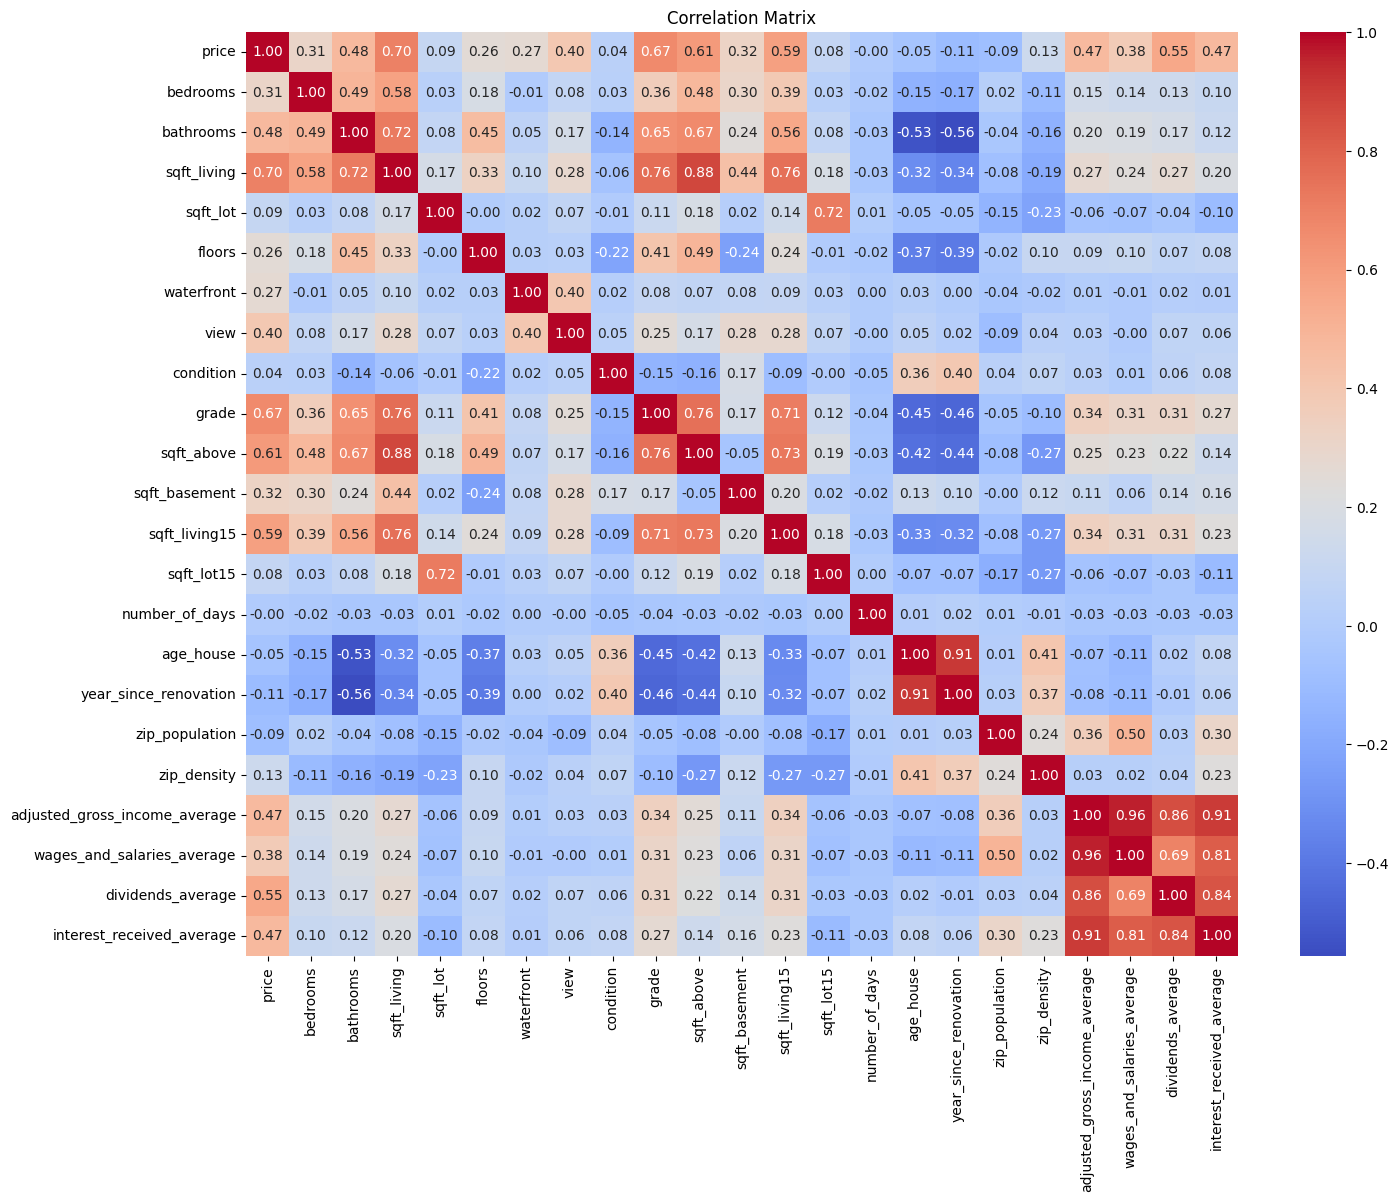

In [90]:
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
dfs_house_assembled = assembler.transform(dfs_house).select("features")

correlation_matrix = Correlation.corr(dfs_house_assembled, "features").head()[0].toArray()

corr_df = pd.DataFrame(correlation_matrix, columns=numeric_cols, index=numeric_cols)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [92]:
corr_df.to_csv("../output/correlation_matrix.csv", index=False)